# Johan Hedenström
Exploration

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import math
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import lists
from filter import filter
import torch
from nflows.transforms import MaskedAffineAutoregressiveTransform, CompositeTransform, RandomPermutation
from nflows.distributions import StandardNormal
from nflows.utils import create_alternating_binary_mask
from nflows.nn.nets import MLP

In [2]:
# Load the data
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-12_S18.lst'
chn = [2048,2048]
header, events, timing = lists.lstRead(FILE_PATH)

In [3]:
# Filtering settings
coin = [True, True, False, False, False, False, False, False]
zdrop = True
outLists = lists.getCoins(events, coin, zdrop)

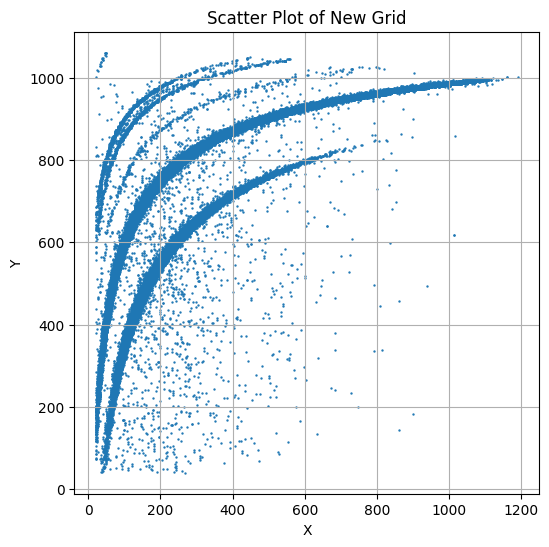

In [4]:
# Load data
energy = np.array(outLists[0])
tof = np.array(outLists[1])
data = np.vstack((energy, tof)).T

# Noise reduction
filtered_data = filter(data, 10, 2)

# Convert filtered data to torch tensor for flow model
data_tensor = torch.tensor(filtered_data, dtype=torch.float32)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(filtered_data[:, 0], filtered_data[:, 1], s=0.5)
plt.title("Scatter Plot of New Grid")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

Epoch 0: Loss = 37.12863540649414
Epoch 1: Loss = 36.347042083740234
Epoch 2: Loss = 35.56660079956055
Epoch 3: Loss = 34.781410217285156
Epoch 4: Loss = 33.98698425292969
Epoch 5: Loss = 33.1785774230957
Epoch 6: Loss = 32.35066604614258
Epoch 7: Loss = 31.49671745300293
Epoch 8: Loss = 30.6091365814209
Epoch 9: Loss = 29.679141998291016


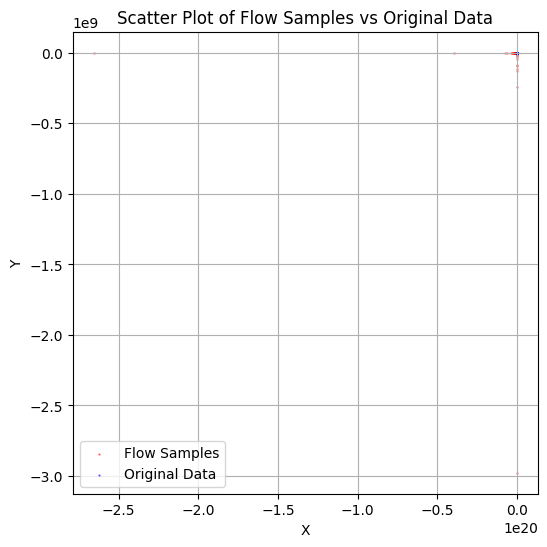

In [9]:
from nflows.flows import Flow

# MaskedAffineAutoregressiveTransform
def create_normalizing_flow(dimensions, num_flows=6, hidden_dim=32):
    transforms = []
    for _ in range(num_flows):
        transforms.append(MaskedAffineAutoregressiveTransform(features=dimensions, hidden_features=hidden_dim))
        transforms.append(RandomPermutation(features=dimensions))
    
    transform = CompositeTransform(transforms)
    base_distribution = StandardNormal([dimensions])
    flow = Flow(transform, base_distribution)

    return flow

data_tensor = (data_tensor - data_tensor.mean(dim=0)) / data_tensor.std(dim=0)

energy_squared = data_tensor[:, 0]
tof_squared = data_tensor[:, 1]
data_tensor = torch.cat([data_tensor, energy_squared.unsqueeze(1), tof_squared.unsqueeze(1)], dim=1)
dimensions = data_tensor.shape[1] 

flow = create_normalizing_flow(dimensions, num_flows=10, hidden_dim=64)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
num_epochs = 10 

# Train
for epoch in range(num_epochs):
    log_prob = flow.log_prob(data_tensor).mean()
    loss = -log_prob
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}: Loss = {loss.item()}")

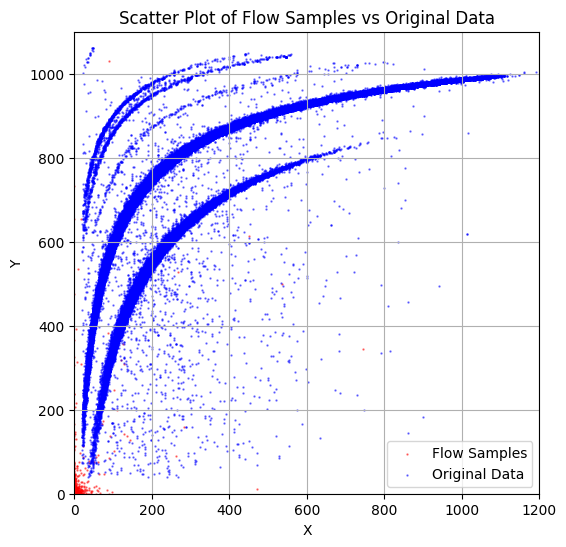

In [10]:
# Plot flow samples and original data
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=0.5, color="red", alpha=0.5, label="Flow Samples")
plt.scatter(filtered_data[:, 0], filtered_data[:, 1], s=0.5, color="blue", alpha=0.5, label="Original Data")
plt.title("Scatter Plot of Flow Samples vs Original Data")
plt.xlabel("X")
plt.ylabel("Y")

plt.xlim(0, 1200)
plt.ylim(0, 1100)

plt.grid(True)
plt.legend()
plt.show()

Epoch 0: Loss = 46.497676849365234
Epoch 10: Loss = 38.170745849609375
Epoch 20: Loss = 25.47309112548828
Epoch 30: Loss = 13.638787269592285
Epoch 40: Loss = 4.739234924316406
Epoch 50: Loss = -3.1586124897003174
Epoch 60: Loss = -8.886222839355469
Epoch 70: Loss = -11.425271987915039
Epoch 80: Loss = -11.691739082336426
Epoch 90: Loss = -13.241706848144531
Epoch 99: Loss = -13.821194648742676


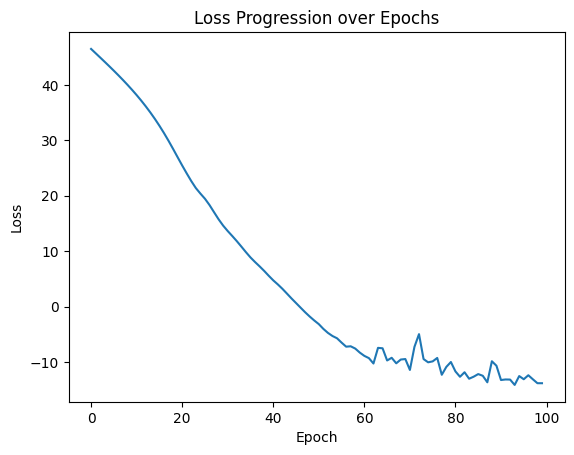

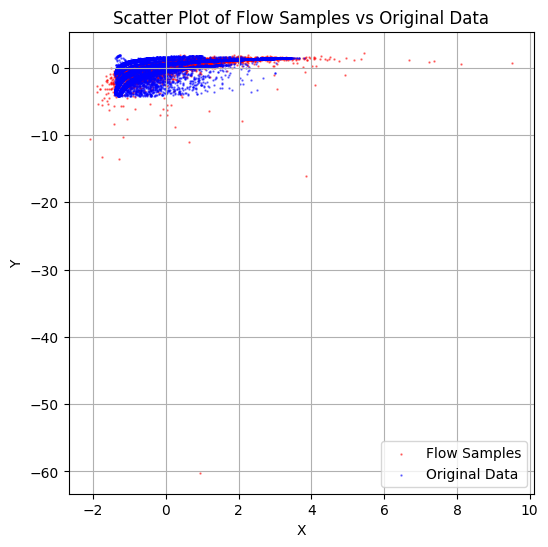

In [18]:
import torch
import matplotlib.pyplot as plt
from nflows.flows import Flow
from nflows.transforms import CompositeTransform, RandomPermutation, MaskedAffineAutoregressiveTransform
from nflows.distributions import StandardNormal

def create_normalizing_flow(dimensions, num_flows=8, hidden_dim=64):
    transforms = []
    for _ in range(num_flows):
        transforms.append(MaskedAffineAutoregressiveTransform(features=dimensions, hidden_features=hidden_dim))
        transforms.append(RandomPermutation(features=dimensions))
    
    transform = CompositeTransform(transforms)
    base_distribution = StandardNormal([dimensions])
    flow = Flow(transform, base_distribution)

    return flow

dimensions = data_tensor.shape[1]
flow = create_normalizing_flow(dimensions)

# Training settings
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
num_epochs = 100 
clip_value = 5
losses = []

# Train
for epoch in range(num_epochs):
    log_prob = flow.log_prob(data_tensor).mean()
    loss = -log_prob
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(flow.parameters(), clip_value)
    optimizer.step()
    
    losses.append(loss.item())
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

# Plot loss progression
plt.figure()
plt.plot(range(num_epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Progression over Epochs")
plt.show()

# Draw samples from flow
with torch.no_grad():
    samples = flow.sample(num_samples=10000)

samples = samples.numpy()
filtered_data = data_tensor.numpy()  

# Plot samples and original data
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=0.5, color="red", alpha=0.5, label="Flow Samples")
plt.scatter(filtered_data[:, 0], filtered_data[:, 1], s=0.5, color="blue", alpha=0.5, label="Original Data")
plt.title("Scatter Plot of Flow Samples vs Original Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()


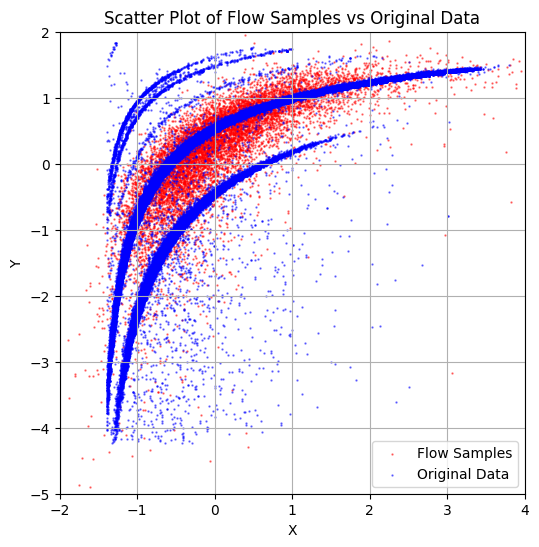

In [33]:
plt.figure(figsize=(6, 6))

# Cap axis ranges for better visualization
plt.xlim(-2, 4)
plt.ylim(-5, 2)

plt.scatter(samples[:, 0], samples[:, 1], s=0.5, color="red", alpha=0.5, label="Flow Samples")
plt.scatter(filtered_data[:, 0], filtered_data[:, 1], s=0.5, color="blue", alpha=0.5, label="Original Data")
plt.title("Scatter Plot of Flow Samples vs Original Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()